In [49]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from scipy import constants
import os
import glob
from matplotlib import rc
from sklearn.metrics import mean_squared_error

In [50]:
from InfluxData import InfluxData
client = InfluxData()
client.set_client('155.230.28.170',8086,'sslab','1231',database='kmaeq')
device_ids = client.get_device()

In [51]:
raw_data = {'dev_id':[],
            'Mean_PSD_x':[],
            'Mean_PSD_y':[],
            'Mean_PSD_z':[],
            'MSE_PSD_x':[],
            'MSE_PSD_y':[],
            'MSE_PSD_z':[]}
new_df = pd.DataFrame(raw_data)
new_df

,dev_id,Mean_PSD_x,Mean_PSD_y,Mean_PSD_z,MSE_PSD_x,MSE_PSD_y,MSE_PSD_z


In [52]:
EXPECT_DATASET_SIZE = 60000 # 10min data
def psd_processing(dev_id:str):
    cli = InfluxData()
    cli.set_client('155.230.28.170',8086,'sslab','1231',database='kmaeq')
    rs = cli.query(f"select * from acc_data where dev_id='{dev_id}' and time >= now() -40m AND time <= now() - 30m")
    data = cli.resultSetToDF(rs)
    if type(data['acc_data']) is list: #  it means empty data
        print('empty data')
        return dev_id
    if len(data['acc_data']) < EXPECT_DATASET_SIZE*0.9: # not enough data size
        print('not enough data size')
        return dev_id
    data = data['acc_data'] # convert dict_dataframe to dataframe
    x = data['x']*constants.g
    y = data['y']*constants.g
    z = data['z']*constants.g
    offset_x = x - np.mean(x)
    offset_y = y - np.mean(y)
    offset_z = z - np.mean(z)
    Pxx, freqs_x = plt.psd(offset_x,NFFT=200,Fs=100)
    Pxx_true = [0 for i in range(len(Pxx))]
    x_mse = mean_squared_error(Pxx,Pxx_true)
    Pyy, freqs_y = plt.psd(offset_y,NFFT=200,Fs=100)
    Pyy_true = [0 for i in range(len(Pyy))]
    y_mse = mean_squared_error(Pyy,Pyy_true)
    Pzz, freqs_z = plt.psd(offset_z,NFFT=200,Fs=100)
    Pzz_true = [0 for i in range(len(Pzz))]
    z_mse = mean_squared_error(Pzz,Pzz_true)
    row = {'dev_id':dev_id,
            'Mean_PSD_x':np.mean(Pxx),
            'Mean_PSD_y':np.mean(Pyy),
            'Mean_PSD_z':np.mean(Pzz),
            'MSE_PSD_x': x_mse,
            'MSE_PSD_y': y_mse,
            'MSE_PSD_z': z_mse
            }
    return row

In [53]:
%%time
from concurrent.futures import ProcessPoolExecutor, as_completed, wait
pool = ProcessPoolExecutor(len(device_ids))
futures = []
for dev_id in device_ids:
    futures.append(pool.submit(psd_processing,dev_id))

err_devices = [] 

for x in as_completed(futures,timeout=120):
    if type(x.result()) is dict:
        new_df = new_df.append(x.result(),ignore_index=True)
    else:
        err_devices.append(x.result())

empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
not enough data size
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
empty data
not enough data size
empty data
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
not enough data size
CPU times: user 952 ms, sys: 1.77 s, total: 2.72 s
Wall time: 20.4 s


In [54]:
'''
while(q.empty() is False):
    new_df = new_df.append(q.get(),ignore_index=True)
new_df
'''
new_df
#new_df['Mean_PSD_x'].describe()

,dev_id,Mean_PSD_x,Mean_PSD_y,Mean_PSD_z,MSE_PSD_x,MSE_PSD_y,MSE_PSD_z
0,0255,8.827718e-07,1.641519e-06,1.652955e-06,7.878389e-13,2.729716e-12,4.113090e-12
1,0018,1.870599e-06,2.000780e-06,2.067574e-06,3.542849e-12,4.067052e-12,5.029059e-12
2,0048,1.764921e-06,2.162331e-06,1.790383e-06,3.148519e-12,4.762619e-12,3.387594e-12
3,0111,6.706694e-06,2.695953e-06,3.913300e-06,9.208878e-10,2.891341e-11,7.044334e-11
4,0064,1.431192e-06,2.788349e-08,2.686720e-06,2.065438e-12,7.843010e-16,7.925486e-12
5,0108,2.008229e-06,1.223919e-07,5.146783e-06,1.039424e-11,1.742236e-14,1.711621e-10
6,0057,1.814079e-06,2.023327e-06,2.582971e-06,3.319623e-12,4.128599e-12,7.422962e-12
7,0091,6.018343e-06,2.069068e-06,6.777270e-06,7.720015e-10,4.990878e-12,6.637938e-10
8,0026,1.877381e-06,2.285492e-06,2.581975e-06,3.618173e-12,5.402540e-12,1.197720e-11
9,0102,1.961687e-06,2.055558e-06,2.535733e-06,3.977242e-12,4.330157e-12,6.667591e-12


In [55]:
cant_qry = set(device_ids) - set(err_devices) - set(new_df['dev_id'])
cant_qry

set()

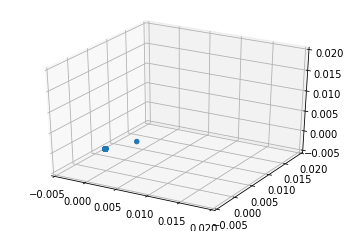

In [56]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = plt.gca(projection='3d')
ax.scatter(new_df['Mean_PSD_x'],new_df['Mean_PSD_y'],new_df['Mean_PSD_z'])
ax.set_xlim(-0.005,0.02)
ax.set_ylim(-0.005,0.02)
ax.set_zlim(-0.005,0.02)
plt.show()

In [57]:
from sklearn.cluster import KMeans
dev_id = new_df['dev_id']
Feature = new_df.loc[:,new_df.columns != 'dev_id']

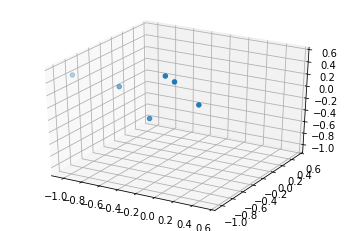

In [95]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#ss = StandardScaler()
#ss = MinMaxScaler()
ss = RobustScaler()
ss.fit(Feature)
Feature = ss.transform(Feature)
Feature
fig = plt.figure()
ax = plt.gca(projection='3d')
ax.scatter(Feature[:][0],Feature[:][1],Feature[:][2])
'''
ax.set_xlim(-0.09,-0.07)
ax.set_ylim(-0.09,-0.07)
ax.set_zlim(-0.09,-0.07)
'''
'''
ax.set_xlim(-0.001,0.001)
ax.set_ylim(-0.001,0.001)
ax.set_zlim(-0.001,0.001)
'''
ax.set_xlim(-1.1,0.6)
ax.set_ylim(-1.1,0.6)
ax.set_zlim(-1.1,0.6)
plt.show()

(181, 6)


In [14]:
kmeans = KMeans(n_clusters=6).fit(Feature)
kmeans_labels = kmeans.labels_
kmeans_results = pd.concat([dev_id,pd.DataFrame(kmeans_labels.reshape(-1,1),columns=['prediction'])],axis=1)
kmeans_outliers = kmeans_results.loc[kmeans_results['prediction'] != 0]

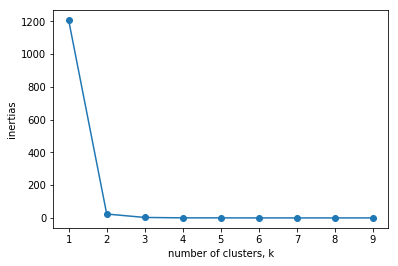

In [15]:
ks = range(1,10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k).fit(Feature)
    inertias.append(model.inertia_)

plt.plot(ks,inertias,'-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertias')
plt.xticks(ks)
plt.show()

In [16]:
kmeans_outliers

,dev_id,prediction
26,0249,5
45,0011,4
85,0211,3
127,0064,2
156,0025,1


In [33]:
np.save('PSD_k-means_center.npy',kmeans.cluster_centers_)
kmeans.cluster_centers_

array([[-0.08841661, -0.08960932, -0.0911136 , -0.07274193, -0.07396849,
        -0.07376685],
       [13.94729408, 13.82374913, 13.83905212, 14.13802406, 14.12936032,
        14.13168501],
       [ 2.05615889,  2.77235021,  2.65696301,  0.26696622,  0.52755617,
         0.47036151],
       [ 0.66614311,  0.78873463,  0.67500959, -0.03177797, -0.01613233,
        -0.03136693],
       [ 0.48577204,  0.09206701,  0.56384412, -0.04844807, -0.07127309,
        -0.04209844],
       [ 0.17428766,  0.08652542,  0.12339693, -0.06734588, -0.0716866 ,
        -0.07027949]])

In [32]:
kmeans_test = KMeans(n_clusters=6)
kmeans_test.cluster_centers_ = kmeans.cluster_centers_
type(kmeans_test.cluster_centers_)

numpy.ndarray

In [31]:
kmeans_test_label = kmeans_test.predict(Feature)
kmeans_test_result = pd.concat([dev_id,pd.DataFrame(kmeans_test_label.reshape(-1,1),columns=['prediction'])],axis=1)
kmeans_test_result
kmeans_test_outliers = kmeans_test_result.loc[kmeans_results['prediction'] !=0]
kmeans_test_outliers

,dev_id,prediction
26,0249,5
45,0011,4
85,0211,3
127,0064,2
156,0025,1
